In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from parameters import *
from lib.utils import *
from lib.attacks import *

import numpy as np
import tensorflow as tf

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/chawins/.conda/envs/tsa3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

y_train_cat = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test_cat = keras.utils.to_categorical(y_test, NUM_LABELS)

In [5]:
def random_sample(size):

    # Generate samples from g
    z = np.random.normal(0, 1, size)
    # Sampled labels
    y_sampled = np.random.randint(0, 10, size[0])
    return z, y_sampled

def generate_random(g, size):

    z, y_sampled = random_sample(size)
    x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
    return x_g, y_sampled

def collage(images):
    img = (np.concatenate([np.concatenate([s for s in r], axis=1)
                           for r in np.split(images, 10)], axis=0) *
           127.5 + 127.5).astype(np.uint8)
    return np.squeeze(img)

def show(x):
    plt.imshow(x.reshape(28, 28) / 2 + 1, cmap='gray')
    plt.axis('off')
    plt.show()

In [153]:
def grad_acgan_cross_entropy(model):
    y_true = K.placeholder(shape=(OUTPUT_DIM, ))
    loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true, logits=model.output)
    grad = K.gradients(loss, model.input[0])
    return K.function([model.input[0], model.input[1], 
                       y_true, K.learning_phase()], grad)

def grad_acgan_hinge(model):
    
    labels = K.placeholder(shape=(OUTPUT_DIM, ), dtype=tf.int32)
    logits = model.output[0]
    i_label = tf.to_int32(tf.argmax(labels))
    y_label = logits[i_label]
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits))
    y_max = tf.where(tf.equal(i_label, i_max), 
                     y_2max[1], y_2max[0])
    loss = tf.maximum(0., 1. - y_label + y_max)
    grad = K.gradients(loss, model.input[0])
    return K.function([model.input[0], model.input[1], 
                       labels, K.learning_phase()], grad)

In [156]:
def PGD(model, x, y, grad_fn=None, norm="2", n_step=40, step_size=0.05,
        target=True, init_rnd=0.1):
    """
    PGD attack with random start
    """
    
    x_adv = np.zeros_like(x)
    y_cat = keras.utils.to_categorical(y, NUM_LABELS)
    
    for i, x_cur in enumerate(x):
        epsilon = np.random.uniform(size=x_cur.shape) - 0.5
        if norm == "2":
            try:
                epsilon /= np.linalg.norm(epsilon)
            except ZeroDivisionError:
                raise
        elif norm == "inf":
            epsilon = np.sign(epsilon)
        else:
            raise ValueError("Invalid norm!")
        
        x_adv[i] = x_cur + init_rnd * epsilon
        
    if not grad_fn:
        grad_fn = gradient_fn(model)
    start_time = time.time()

    for i, x_in in enumerate(x_adv):
        print(i)
        x_cur = np.copy(x_in)
        # Start update in steps
        for _ in range(n_step):
            grad = grad_fn([x_in.reshape(1, -1), y[i].reshape(1, -1), 
                            y_cat[i], 0])[0][0]
            if target:
                grad *= -1
            if norm == "2":
                try:
                    grad /= np.linalg.norm(grad)
                except ZeroDivisionError:
                    raise
            elif norm == "inf":
                grad = np.sign(grad)
            else:
                raise ValueError("Invalid norm!")

            x_cur += grad * step_size
            loss = model.evaluate([x_cur[np.newaxis], y[i, np.newaxis]], 
                                  y[i, np.newaxis], verbose=0)[0]
#             out = model.predict([x_cur[np.newaxis], y[i, np.newaxis]], 
#                                 verbose=0)[0]
#             if np.argmax(out) != y[i]:
#                 loss = np.maximum(0, 1 - out[y[i]] + np.sort(out)[-1])
#             else:
#                 loss = np.maximum(0, 1 - out[y[i]] + np.sort(out)[-2])
            print(loss)

        x_adv[i] = np.copy(x_cur)

        # Progress printing
        if (i % 200 == 0) and (i > 0):
            elasped_time = time.time() - start_time
            print("Finished {} samples in {:.2f}s.".format(i, elasped_time))
            start_time = time.time()

    return x_adv

--- 

In [31]:
model = build_cnn_mnist()
#model.load_weights('./tmp/weights/mnist_cnn_hinge.h5')
model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')
#model.load_weights('./tmp/mnist_cnn_margin_C1_L1/model.h5')
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [32]:
from lib.gan.model_acgan_mnist import *

latent_dim = 100
d = build_discriminator()
g = build_generator(latent_dim)
d.load_weights('./tmp/acgan_mnist/weight_d_epoch017.h5')
g.load_weights('./tmp/acgan_mnist/weight_g_epoch017.h5')

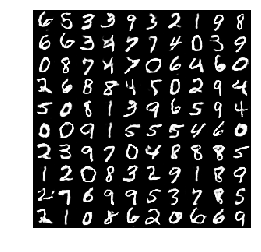

[6, 5, 3, 3, 9, 3, 2, 1, 9, 8]   [0.52, 0.66, 0.47, 0.48, 0.46, 0.43, 0.56, 0.56, 0.46, 0.53]
[6, 6, 3, 4, 7, 7, 4, 0, 3, 9]   [0.55, 0.48, 0.59, 0.64, 0.55, 0.53, 0.54, 0.56, 0.45, 0.39]
[0, 8, 7, 4, 7, 0, 6, 4, 6, 0]   [0.51, 0.46, 0.44, 0.55, 0.5, 0.43, 0.54, 0.56, 0.55, 0.48]
[2, 6, 8, 8, 4, 5, 0, 2, 9, 4]   [0.51, 0.49, 0.53, 0.34, 0.5, 0.43, 0.58, 0.45, 0.44, 0.44]
[5, 0, 8, 1, 3, 9, 6, 5, 9, 4]   [0.49, 0.58, 0.46, 0.56, 0.5, 0.44, 0.55, 0.46, 0.46, 0.44]
[0, 0, 9, 1, 5, 5, 5, 4, 6, 0]   [0.52, 0.48, 0.52, 0.56, 0.43, 0.45, 0.37, 0.43, 0.68, 0.46]
[2, 3, 9, 7, 0, 4, 8, 8, 8, 5]   [0.52, 0.69, 0.44, 0.52, 0.51, 0.5, 0.57, 0.54, 0.42, 0.49]
[1, 2, 0, 8, 3, 2, 9, 1, 8, 9]   [0.56, 0.58, 0.46, 0.52, 0.53, 0.55, 0.44, 0.56, 0.49, 0.45]
[2, 7, 6, 9, 9, 5, 3, 7, 8, 5]   [0.44, 0.59, 0.67, 0.47, 0.47, 0.43, 0.49, 0.52, 0.51, 0.47]
[2, 1, 0, 8, 6, 2, 0, 6, 6, 9]   [0.47, 0.56, 0.55, 0.41, 0.58, 0.46, 0.46, 0.58, 0.62, 0.46]


In [33]:
x_g, _ = generate_random(g, (100, latent_dim))
plt.imshow(collage(x_g), cmap='gray')
plt.axis('off')
#plt.savefig('acgan_latent.png', bbox_inches='tight')
plt.show()

y_pred = []
fake = []

for i, x in enumerate(x_g):
    tmp = d.predict(x.reshape(1, 28, 28, 1))
    fake.append(round(float(tmp[0]), 2))
    y_pred.append(np.argmax(tmp[1]))
    if (i + 1) % 10 == 0:
        print("{}   {}".format(y_pred, fake))
        y_pred = []
        fake = []

In [34]:
latent = Input(shape=(latent_dim, ))
image_class = Input(shape=(1, ), dtype='int32')
img = g([latent, image_class])
y = model(img)
combine = Model(inputs=[latent, image_class], outputs=y)
combine.trainable=False
combine.compile(loss=keras.losses.sparse_categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

In [180]:
z, y = random_sample((10, latent_dim))
y_cat = keras.utils.to_categorical(y, NUM_LABELS)

In [181]:
grad_fn = grad_acgan_cross_entropy(combine)
# grad_fn = grad_acgan_hinge(combine)
x_adv = PGD(combine, z, y, grad_fn=grad_fn, norm="2", n_step=200, 
            step_size=0.01, target=False, init_rnd=0.1)

0
0.4597225785255432
0.4970799684524536
0.5313109159469604
0.5638300180435181
0.5960965156555176
0.6264375448226929
0.6580941081047058
0.6888614892959595
0.6931475400924683
0.6931475400924683
0.6931475400924683
0.6931475400924683
0.6931475400924683
0.6931475400924683
0.7182260751724243
0.7642896175384521
0.8064066767692566
0.8482104539871216
0.8855888247489929
0.9186537265777588
0.9494692087173462
0.9776800870895386
1.0044721364974976
1.0240389108657837
1.043177604675293
1.0608536005020142
1.0722895860671997
1.0851056575775146
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.098612546

1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.072883037

0.2327650785446167
0.35156962275505066
0.4561910629272461
0.5450170040130615
0.6194179058074951
0.6904576420783997
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.693147659

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6979542970657349
0.7040797472000122
0.7089264392852783
0.7134661078453064
0.7183966040611267
0.7212288975715637
0.724156379699707
0.7258964776992798
0.725147008895874
0.7246922254562378
0.7229621410369873
0.7149119973182678
0.7044547200202942
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.693147659301

In [182]:
x = g.predict([x_adv, y])

In [183]:
y

array([2, 9, 1, 1, 4, 4, 5, 1, 6, 6])

In [184]:
np.argmax(combine.predict([x_adv, y]), axis=1)

array([2, 9, 1, 1, 4, 4, 5, 1, 6, 6])

In [185]:
np.argmax(model.predict(x), axis=1)

array([2, 9, 1, 1, 4, 4, 5, 1, 6, 6])

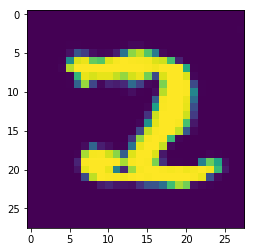

[[-5.5808177 -0.6756376  5.18525   -3.6365104 -5.456025  -6.2445245
  -4.8278346  2.2106686 -4.557098  -6.1875567]]


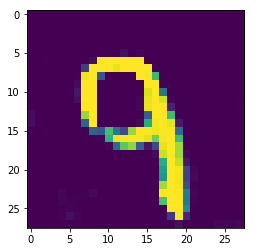

[[-10.803802   -5.7788806  -7.418743   -3.1510973   3.687369   -3.3082128
  -13.5088625   5.136135   -7.4579897   6.424499 ]]


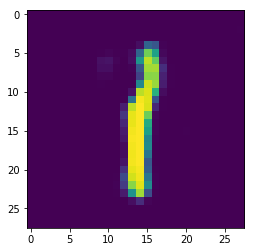

[[-10.486144    8.70629    -8.4575     -4.799576   -1.8021522  -2.6582544
   -5.210845   -1.7553296  -6.576055   -6.243638 ]]


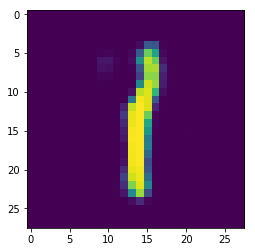

[[-10.620914    8.854335   -8.582495   -4.9599547  -1.8127798  -2.7013652
   -5.3833966  -1.8152598  -6.610757   -6.2845964]]


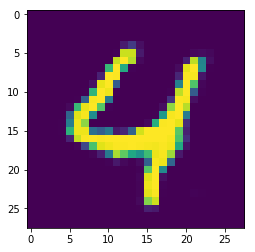

[[-15.515845   -1.6977649 -10.23984   -15.428657   12.092033  -10.141016
  -13.178855   -2.3992014  -6.734728    5.290235 ]]


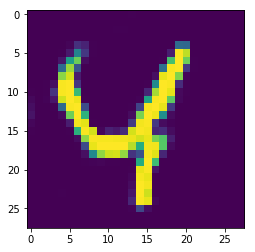

[[-18.330046    4.276281  -15.719414   -9.189944    7.9724565  -5.6268444
  -11.0775385   6.5871363  -7.9456406  -2.2246463]]


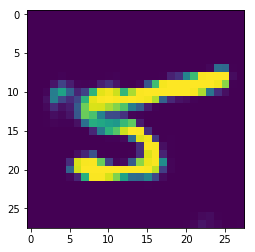

[[-15.830535   -5.4194975 -26.42333     3.9659371 -23.094276   20.8291
   -8.990696  -17.534702  -14.968137  -17.613762 ]]


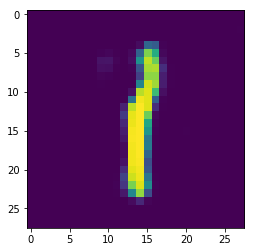

[[-10.644046    8.864652   -8.445669   -4.828279   -1.8971465  -2.697466
   -5.3441706  -1.927721   -6.662926   -6.379666 ]]


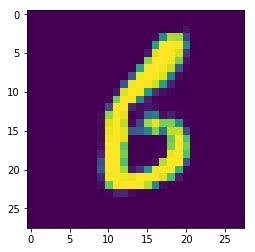

[[ -4.5699916   -4.859029   -12.461263    -0.23061533  -8.454523
    3.7223995    8.926257    -9.948452    -2.2751937  -11.769989  ]]


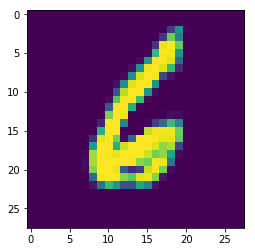

[[-4.4337425 -3.1511374 -3.462468  -4.8845844 -2.7794638  0.9756431
   5.1662035 -6.1870537 -1.1074718 -6.0694866]]


In [186]:
for x_cur in x:
    plt.imshow(x_cur.reshape(28, 28))
    plt.show()
    print(model.predict(x_cur.reshape(1, 28, 28, 1)))

In [170]:
np.max(x_adv[1])

2.4402044988261253

---
Simply iterate until a misclassification is found

In [101]:
adv_found = False
i = 0
while not adv_found:
    i += 1
    z, y = random_sample((100, latent_dim))
    y_pred = np.argmax(combine.predict([z, y]), axis=1)
    if np.sum(y_pred == y) != 100:
        z_adv, y_adv = z[y_pred != y], y[y_pred != y]
        break
print(i * 100)

500


In [102]:
np.sum(y_pred == y)

99

In [103]:
x = g.predict([z_adv, y_adv])

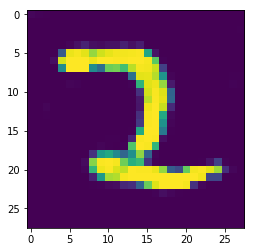

In [105]:
plt.imshow(x.reshape(28, 28))

In [106]:
np.argmax(model.predict(x), axis=1)

array([1])

In [ ]:
# try different loss function

---

In [217]:
from lib.OptCarlini_GAN import *

z, y = random_sample((10, latent_dim))
y_cat = keras.utils.to_categorical(y, NUM_LABELS)

opt = OptCarlini_GAN(combine, target=False, c=1, lr=0.01, init_scl=0.1,
                     loss_op=0, k=0, use_mask=False, decay=True)

x_adv = np.zeros_like(z)
norm = np.zeros(len(z))

for i, (zi, yi) in enumerate(zip(z, y_cat)):
    x_adv[i], norm[i] = opt.optimize(zi, yi, 
                                     'temp.h5', 
                                     n_step=1000, prog=True)

Step: 0, norm=0.938, loss=14.329, obj=15.267
Step: 50, norm=0.776, loss=8.884, obj=9.660
Step: 100, norm=1.626, loss=5.487, obj=7.113
Step: 150, norm=1.599, loss=5.245, obj=6.844
Step: 200, norm=1.626, loss=5.199, obj=6.825
Step: 250, norm=1.626, loss=5.187, obj=6.813
Step: 300, norm=1.634, loss=5.168, obj=6.802
Step: 350, norm=1.643, loss=5.159, obj=6.802
Step: 400, norm=1.650, loss=5.151, obj=6.801
Step: 450, norm=1.655, loss=5.148, obj=6.803
Step: 500, norm=1.663, loss=5.138, obj=6.801
Step: 550, norm=1.671, loss=5.132, obj=6.802
Step: 600, norm=1.677, loss=5.124, obj=6.801
Step: 650, norm=1.683, loss=5.116, obj=6.799
Step: 700, norm=1.682, loss=5.116, obj=6.798
Step: 750, norm=1.681, loss=5.118, obj=6.799
Step: 800, norm=1.681, loss=5.117, obj=6.799
Step: 850, norm=1.682, loss=5.116, obj=6.798
Step: 900, norm=1.681, loss=5.117, obj=6.799
Step: 950, norm=1.687, loss=5.113, obj=6.799
Step: 0, norm=0.940, loss=9.052, obj=9.992
Step: 50, norm=0.791, loss=2.398, obj=3.189
Step: 100, nor

Step: 150, norm=1.867, loss=7.511, obj=9.378
Step: 200, norm=2.080, loss=6.874, obj=8.954
Step: 250, norm=2.093, loss=6.747, obj=8.840
Step: 300, norm=2.143, loss=6.643, obj=8.786
Step: 350, norm=2.186, loss=6.593, obj=8.778
Step: 400, norm=2.220, loss=6.547, obj=8.767
Step: 450, norm=2.283, loss=6.473, obj=8.756
Step: 500, norm=2.328, loss=6.354, obj=8.682
Step: 550, norm=2.461, loss=6.149, obj=8.610
Step: 600, norm=2.614, loss=5.872, obj=8.486
Step: 650, norm=2.799, loss=5.618, obj=8.417
Step: 700, norm=2.857, loss=5.548, obj=8.405
Step: 750, norm=2.938, loss=5.425, obj=8.363
Step: 800, norm=3.023, loss=5.258, obj=8.281
Step: 850, norm=3.037, loss=5.236, obj=8.273
Step: 900, norm=3.041, loss=5.231, obj=8.272
Step: 950, norm=3.039, loss=5.233, obj=8.272


In [218]:
y

array([3, 4, 7, 3, 9, 5, 7, 9, 2, 5])

In [219]:
np.argmax(combine.predict([x_adv, y]), axis=1)

array([3, 9, 7, 5, 7, 9, 7, 7, 2, 5])

In [221]:
x = g.predict([x_adv, y])
np.argmax(model.predict(x), axis=1)

array([3, 9, 7, 5, 7, 9, 7, 7, 2, 5])

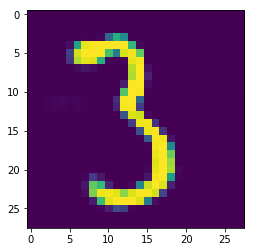

[[-13.947551   -2.5463428 -15.383526   13.285285  -15.662439    8.172025
   -9.489777  -15.630919  -11.500274   -8.989867 ]]


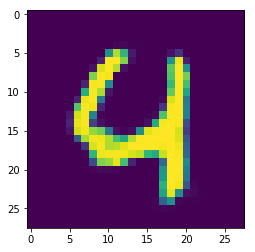

[[-8.1213665 -2.4166136 -5.5436773 -8.786619   5.99627   -4.4344053
  -5.173019  -5.0745173 -2.5112922  5.9969425]]


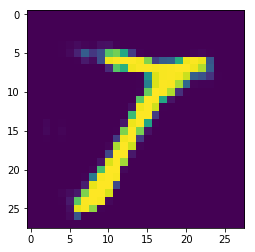

[[-10.372351    5.3420715  -6.9031405  -6.2488923  -1.013377   -5.8595805
  -11.067628    7.0684123  -4.324375   -2.569461 ]]


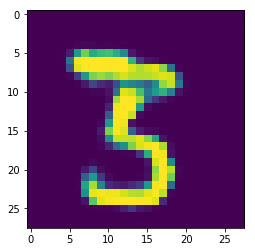

[[-14.225002  -10.876545  -18.65113    13.020689  -20.970278   13.02366
  -10.471831  -16.219648   -7.2098036  -5.78896  ]]


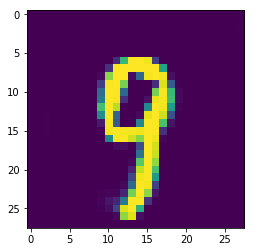

[[-8.74838   -2.752154  -7.652236  -3.8059962  0.8605508 -1.5504112
  -9.8480835  3.649233  -6.7129507  3.649112 ]]


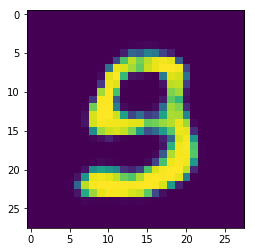

[[-3.4094229  -1.8606191  -4.618221   -3.7925181   0.03810091  2.511759
  -6.745173   -2.8156793  -6.111154    2.5123937 ]]


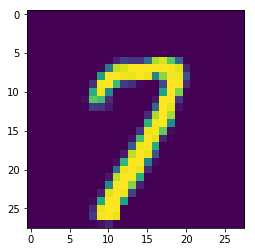

[[-9.393818   -2.604566   -2.0521085  -2.8589025  -2.026993   -6.9077287
  -9.328206    6.5981593  -6.2274647  -0.04986502]]


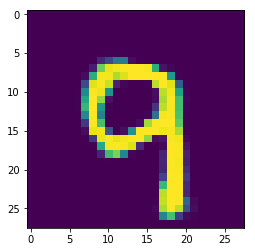

[[ -9.523609    -6.4053826   -6.8474126   -1.5410839   -0.65240574
   -0.69709224 -12.571698     4.2805367   -4.576186     4.2799487 ]]


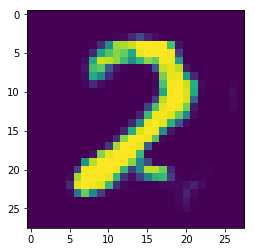

[[-4.1144276 -5.8187785  6.593252  -4.064546  -8.01332   -7.3271184
  -6.3371353 -1.633298   3.4212575 -4.252313 ]]


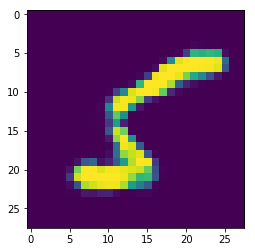

[[-10.278819    -0.45332065 -13.34796      3.3401175  -10.859816
    8.574158    -2.5602999   -9.653444    -9.348736   -10.045826  ]]


In [222]:
for x_cur in x:
    plt.imshow(x_cur.reshape(28, 28))
    plt.show()
    print(model.predict(x_cur.reshape(1, 28, 28, 1)))

In [172]:
combine.save_weights('temp.h5')

In [174]:
latent = Input(shape=(latent_dim, ))
image_class = Input(shape=(1, ), dtype='int32')
img = g([latent, image_class])
y = model(img)
combine = Model(inputs=[latent, image_class], outputs=y)

In [175]:
combine.load_weights('temp.h5')

In [208]:
combine.input[0].shape[1].value

100

In [214]:
combine.get_input_at(0)

[<tf.Tensor 'input_11:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'input_12:0' shape=(?, 1) dtype=int32>]